# A fourth template: with a better train/validation/test split

*This notebook differs from the third in more rigorously separating cross-validation from testing. We only use predictions on a held-out test set for the final analysis, but repeat the train/validation versus test split five times, so we can make predictions on the whole corpus. The changes start in the section 'Separate train and validation from final test set.' Everything up to there remains the same.*

For a first test, let's consider the problem of author gender. We know our data model of gender is imperfect (limited for the most part to m/f), and we don't imagine a predictive model trained on this boundary will tell us very much about gender directly; it's almost certainly, to some degree, a proxy for genre. But it's a tricky boundary to model and thus a good place to start. We're in no danger of getting 100% accuracy!

Our ultimate goal in this experiment, and other experiments based on this template, is to figure out:

1. What kinds of *historical questions* are really distorted by the errors in digital libraries? Our working hypothesis is that certain boundaries (like genre and date) are likely to be more sensitive than others (like e.g. gender), because the errors are in practice not distributed randomly.

2. What kinds of *errors* are most likely to produce distortion? I'm acting on the hypothesis (or hunch) that paratext is at least as big a problem as the better-studied problem of OCR error. For instance, the paratext in works of fiction is often from a different genre, and composed at a different time, than the original work. So it's very likely to distort conclusions.

### Imports

In [1]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

### Volume metadata

This metadata file is in the GitHub repo. It has one row for each clean volume. 

Not all of these volumes have been trimmed and chunked; we will rely on the Box folders for a list of the chunks actually available to model. But then we will use this list in order to get features like genre, gender, and date.

In [2]:
volmeta = pd.read_csv('../metadata/updatedvolumemetadata.tsv', sep = '\t')

In [3]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


Here's a function we can use to generate a simpler genre column for modeling the biography / fiction boundary.

In [4]:
def simplify_genre(genrestring):
    genres = [x.strip() for x in genrestring.split('|')]
    if 'bio' in genres:
        return 'bio'
    elif 'fic' in genres:
        return 'fic'
    else:
        print('anomaly', genrestring)
        return float('nan')

volmeta['simplegenre'] = volmeta['genre'].apply(simplify_genre)

anomaly dutch


### Works we have actually trimmed and chunked so far

The Box folders ```cleannarratives``` and ```dirtynarratives``` store processed texts.

The ```cleannarratives``` folder consists of Gutenberg texts, manually trimmed and then automatically chunked to contain ~80,000 characters each.

The ```dirtynarratives``` folder contains Hathi texts that have *not* been trimmed. The only clean-up done on these so far is that running headers have been removed. They've also been chunked to contain ~80,000 characters each, but the boundaries are not aligned with ```cleannarratives.```

Note that the number of files will not be the same in these two folders, and the number of chunks for each volume will not be the same. They are chunked independently.

In [5]:
cleanfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/cleannarratives/')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/dirtynarratives/')
               if x.endswith('.txt')]

In [6]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


What is actually in these data objects?

In [7]:
cleanfiles[0]

'36965_3.txt'

How many *volumes* have we trimmed and chunked so far?

In [8]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [9]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


Let's create a dataframe with just the volumes we're actually using.

In [10]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 25)

### Balancing the distribution of classes across time

Language change is very easy to model, so if you try to model the boundary between two categories that happen to be distributed differently across time (in your collection), you're very likely to get a model of language change. That's a problem if you want to study the categorical difference in itself, separated from confounding issues of chronology that might just be selection bias.

Here we're distinguishing books written by men from those written by women. And although we don't really care about the model in its own right (since we're interested in the consequences of OCR distortion), it's still important to know what we're modeling, because OCR distortion could have *different* effects on different kinds of boundaries (e.g. chronological or demographic). 

So we need to be careful to balance the classes across time. At a minimum, we should require the median date for both categories to be roughly the same. A more ambitious approach would match the full distribution. But for right now let's keep it simple.

Also, in order to keep things simple, let's select both classes to be the same size. So we'll match the size of the smaller class.

In [11]:
indexes_f = ourtitles.loc[ourtitles.authgender == 'f', : ].index.tolist()
indexes_m = ourtitles.loc[ourtitles.authgender == 'm', : ].index.tolist()
print('The smaller class has ', len(indexes_f), ' volumes.')

The smaller class has  139  volumes.


The following function selects a matching number of volumes while keeping the median date similar in both categories.

In [12]:
def match_medians(smaller_indexes, larger_indexes, metadata):
    '''
    smaller_indexes = indexes of metadata for the smaller class
    larger_indexes = indexes of metadata for the larger class
    '''
    selected_from_large = []
    smaller_median = np.median(metadata.loc[smaller_indexes, 'latestcomp'])
    
    largerdf = metadata.loc[larger_indexes, : ]
    above_median = largerdf.loc[largerdf['latestcomp'] >= smaller_median, : ].index.tolist()
    below_median = largerdf.loc[largerdf['latestcomp'] <= smaller_median, : ].index.tolist()
    
    for i in range(len(smaller_indexes)):
        if len(selected_from_large) > 0:
            larger_median = np.median(metadata.loc[selected_from_large, 'latestcomp'])
        else:
            larger_median = smaller_median
        
        if larger_median >= smaller_median and len(below_median) > 0:
            selected = random.sample(below_median, 1)[0]
            below_median.pop(below_median.index(selected))
            selected_from_large.append(selected)
        elif larger_median <= smaller_median and len(above_median) > 0:
            selected = random.sample(above_median, 1)[0]
            above_median.pop(above_median.index(selected))
            selected_from_large.append(selected)
        else:
            # we have no more items that won't distort the median
            break

    return selected_from_large, smaller_median, larger_median

selected_m, median_f, median_m = match_medians(indexes_f, indexes_m, ourtitles)  

In [13]:
print(median_f, median_m, len(selected_m))

1890.0 1889.5 139


In [14]:
all_selected_vols = indexes_f + selected_m
len(all_selected_vols)

278

We've gathered the actual indexes of rows in ```ourtitles.``` Now let's convert those to Gutenberg indexes (or other clean-volume identifiers, in cases where volumes are drawn from ECCO, etc.)

In [15]:
selected_gbindexes = ourtitles.loc[all_selected_vols, 'gbindex']

### Merging chunk and volume

So far we've been operating at the volume level. But we will need chunk-level metadata in order to actually model the files.

Let's create dataframes that have a row for each chunk and merge those dataframes with the information in volmeta.

In [16]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [17]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.shape

(2489, 26)

In [18]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.shape

(2610, 26)

Now we select the subsets of those dataframes with Gutenberg indexes that were selected by the match_medians function.

In [19]:
cleanmodelmeta = cleanmeta.loc[cleanmeta['gbindex'].isin(selected_gbindexes), : ]
cleanmodelmeta.shape

(1537, 26)

In [20]:
dirtymodelmeta = dirtymeta.loc[dirtymeta['gbindex'].isin(selected_gbindexes), : ]
dirtymodelmeta.shape

(1619, 26)

### Term-document matrices for clean and dirty narratives 


In [21]:
clean_rootdir = '/Users/tunder/Box Sync/NEHproject/cleannarratives/'

clean_paths = []

for chunk_id in cleanmodelmeta['chunkid']:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')
    

In [22]:
clean_model_chunk_ids = cleanmodelmeta['chunkid']

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,120,12th,13,...,youth,youthful,youths,zeal,zealous,zenith,zest,zigzag,zone,æsthetic
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
36965_2,0,2,0,0,2,0,2,0,1,2,...,0,0,0,1,0,0,0,0,0,0
36965_0,0,0,0,0,0,0,0,0,1,0,...,9,2,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,0
36965_4,0,2,0,1,1,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0


In [23]:
dirty_rootdir = '/Users/tunder/Box Sync/NEHproject/dirtynarratives/'

dirty_paths = []

for chunk_id in dirtymodelmeta['chunkid']:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymodelmeta['chunkid']
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſurpriſed,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſword,ſº,ﬁnd,ﬁrst
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_4,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Turn wordcounts into normalized frequencies

In [24]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [25]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [26]:
dirty_freqs.head()

,00,000,01,10,100,101,102,103,104,105,...,ſurpriſed,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſword,ſº,ﬁnd,ﬁrst
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0.000000,0.0,0.0,0.000074,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_0,0.000000,0.0,0.0,0.000000,0.000073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_4,0.000216,0.0,0.0,0.000072,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice the eighteenth-century long S's!

### Separate train & validation from final test set

**Here is where I begin to change the procedure from the third notebook.** Originally we created a single 3/4, 1/4 split: we optimized parameters on the 3/4 (training/validation) set, and then confirmed accuracy using those optimized parameters on the 1/4 (final test) set. In the new version we will repeat a 4/5, 1/5 split five times so we can test on all of our data.

This will arguably provide us a slightly more accurate estimate.

I don't know whether I've always aligned the terms "train," "validation," and "test" with the way I'm using them here; it's a confused topic, but I think this is the most common way of using them: https://machinelearningmastery.com/difference-test-validation-datasets/

In [47]:
# First we create five lists of authors, to be held out in different iterations.

selected_authors = list(set(volmeta.loc[volmeta['gbindex'].isin(selected_gbindexes), 'author']))
random.shuffle(selected_authors)

fivetestsets = np.array_split(selected_authors, 5)  # this numpy function takes care of the split
testlengths = [len(x) for x in fivetestsets]
testlengths

[46, 46, 46, 45, 45]

In [29]:
# Now we define a function that will return training and testing data (normalized frequencies)
# given a list of authors in a particular test set (any one of the five we just created).

def clean_and_dirty_freqs(atestset, cleanmodelmeta, dirtymodelmeta, clean_freqs, dirty_freqs):
    
    cleantrain = cleanmodelmeta.loc[~cleanmodelmeta['author'].isin(atestset), : ]
    cleantest = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(atestset), : ]
    cleantrain_freqs = clean_freqs.loc[cleantrain.chunkid]
    cleantest_freqs = clean_freqs.loc[cleantest.chunkid]

    dirtytrain = dirtymodelmeta.loc[~dirtymodelmeta['author'].isin(atestset), : ]
    dirtytest = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(atestset), : ]
    dirtytrain_freqs = dirty_freqs.loc[dirtytrain.chunkid]
    dirtytest_freqs = dirty_freqs.loc[dirtytest.chunkid]
    
    return cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs

Let's test the function.

In [32]:
cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs = clean_and_dirty_freqs(fivetestsets[0],
                                                                                cleanmodelmeta, dirtymodelmeta, 
                                                                                 clean_freqs, dirty_freqs)

print('Clean training set: ', cleantrain.shape)
print('Clean test set: ', cleantest.shape)
print('Hathi training set: ', dirtytrain.shape)
print('Hathi testing set: ', dirtytest.shape)

Clean training set:  (1207, 26)
Clean test set:  (330, 26)
Hathi training set:  (1267, 26)
Hathi testing set:  (352, 26)


### Let's produce a model for the clean counts

In the third version of this notebook, you manually ran the grid search until you were confident that the range of parameters you were testing had "surrounded" the optimal value. In other words, we don't (usually) want the optimal parameters to be right at the edge of the space we're testing. That might imply there are even better parameters just slightly outside our scope! We want to find a place where, whichever direction you move, you're going to do worse. (Date prediction is an exception here because the real limit is just that we don't want to bother with a gigantic 100,000 feature model that would take forever to train.)

We are now going to try to *automate* that process. But it would be hard to automate the judgment about whether optimal values are "surrounded." So you should still apply your own judgment to ensure that parameter scope is sufficient to ensure that they are, and edit the code if necessary to ensure it.

We have five different training sets. In each pass across a training set, we're going to do a grid search for the best model. The outer loop will select the number of features. The inner loop will select the regularization constant.


In [35]:
def get_doc_freqs(X, y):
    return np.count_nonzero(X, axis=0)  

docfreqs = []
for col in clean_wordcounts.columns:
    docfreqs.append((sum(clean_wordcounts[col] > 0), col))
docfreqs.sort()

1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
7000


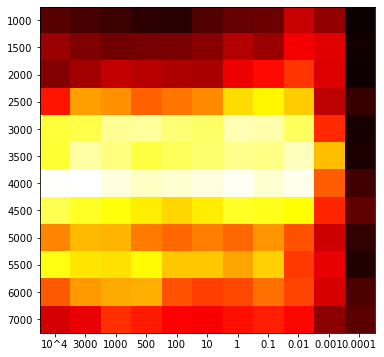

(4000, 3000)
0.7970588235294118
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
7000


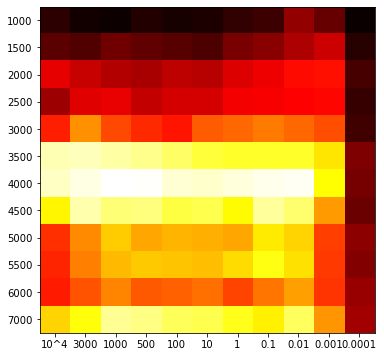

(4000, 1000)
0.7593220338983051
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
7000


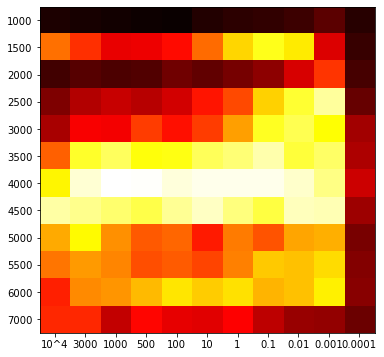

(4000, 1000)
0.7523510971786834
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
7000


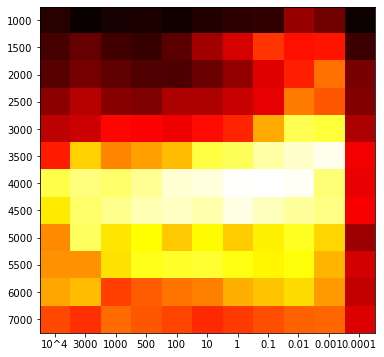

(4000, 0.1)
0.815068493150685
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
7000


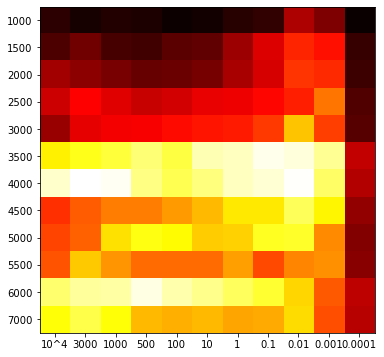

(4000, 3000)
0.6941580756013745


In [48]:
clean_chunkids = []
clean_predictions = []
clean_probabilities = []

for testset in fivetestsets:
    cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, na1, na2, na3, na4 = clean_and_dirty_freqs(testset,
                                                                                cleanmodelmeta, dirtymodelmeta, 
                                                                                 clean_freqs, dirty_freqs)
    # Note that I give the dirty sets variable names that begin NA (not applicable)
    # because we're not using them right now 
    
    resultarray = []
    resultlist = []
    paramlist = []

    featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 7000]
    c_options = [10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

    for featurecount in featureoptions:
        print(featurecount)
        docfreqs = []
        for col in cleantrain_freqs.columns:
            docfreqs.append((sum(cleantrain_freqs[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order

        model_features = cleantrain_freqs.loc[ : , features]

        resultrow = []

        for c_param in c_options:
            logreg = LogisticRegression(C = c_param, max_iter = 2000)
            scaler = StandardScaler()
            # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
            pipe = Pipeline([
                # ('fkb', feature_selector),
                ('sc', scaler),
                ('lr', logreg)
            ])    
            grouper = GroupKFold(n_splits = 10)
            cv_results = cross_validate(estimator = pipe, 
                                        X = model_features,
                                        y = cleantrain['authgender'], 
                                        groups = cleantrain['author'], 
                                        cv = grouper)
            mean_score = np.mean(cv_results['test_score'])
            resultrow.append(mean_score)
            resultlist.append(mean_score)
            paramlist.append((featurecount, c_param))

        resultarray.append(resultrow)
    
    # Let's visualize the grid search for this model pass.
    
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    
    fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(resarray, cmap='hot', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in c_options]
    thexlabels[0] = '10^4'
    plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
    plt.show()
    
    # now find best parameters for this model pass
    
    bestrun = resultlist.index(max(resultlist))
    bestparams = paramlist[bestrun]
    print(bestparams)
    
    best_featurecount, best_c_param = bestparams
    
    # apply those parameters to create an optimal model
    
    features = [x[1] for x in docfreqs[-best_featurecount: ]] # negative because sorted ascending

    train_features = cleantrain_freqs.loc[ : , features]  

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    bestmodel = LogisticRegression(C = best_c_param, max_iter = 2000)

    ## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

    bestmodel = LogisticRegression(C = .001, max_iter = 2000)
    bestmodel.fit(train_features, cleantrain['authgender'])

    test_features = cleantest_freqs.loc[ : , features] 
    test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                    # to train features; we DON'T fit a new one to the
                                                    # test features. We deliberately blind ourselves to that
                                                    # information.

    these_predictions = bestmodel.predict(test_features)
    these_probabilities = bestmodel.predict_proba(test_features)
    clean_predictions.extend(these_predictions)
    clean_probabilities.extend(these_probabilities)
    clean_chunkids.extend(cleantest.chunkid.tolist())
    
    accuracy = sum(these_predictions == cleantest['authgender']) / len(cleantest['authgender'])
    print(accuracy)
     

### put cleanmodelmeta in the right order to correspond to this

In [49]:
cleanmodelmeta.set_index('chunkid', inplace = True)
print(cleanmodelmeta.shape)
cleanmodelmeta = cleanmodelmeta.loc[clean_chunkids, : ]
cleanmodelmeta.reset_index(inplace = True)
cleanmodelmeta.shape

(1537, 25)


(1537, 26)

### Assess overall accuracy

In [50]:
clean_predictions =  [item for sublist in clean_predictions for item in sublist]
accuracy = sum(clean_predictions == cleanmodelmeta['authgender']) / len(cleanmodelmeta['authgender'])
print(accuracy)

0.7644762524398179


This is lower than we were getting before for this task, and I want to double-check to make sure I'm doing this right. But it *is* possible that we were getting a lucky bounce before.

### Now a model for the dirty counts

1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


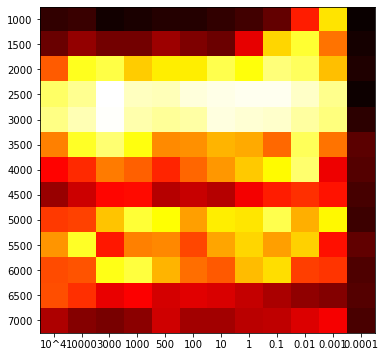

(2500, 3000)
0.7683923705722071
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


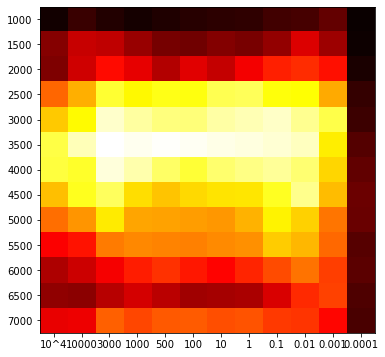

(3500, 3000)
0.7305194805194806
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


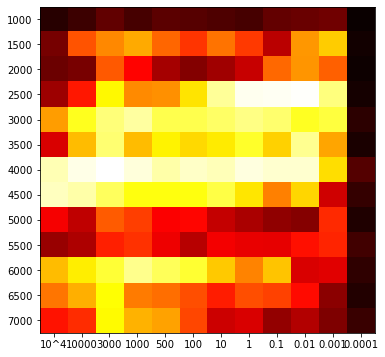

(4000, 3000)
0.7617647058823529
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


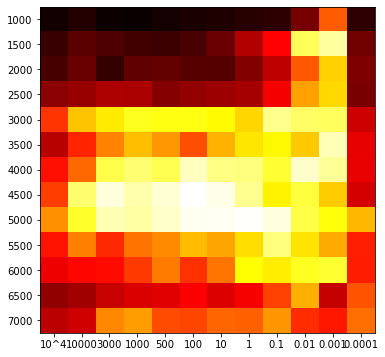

(4500, 100)
0.8327868852459016
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


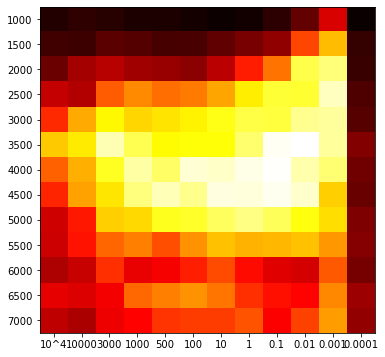

(3500, 0.01)
0.6454849498327759


In [53]:
featureoptions = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000]
c_options = [100000, 10000, 3000, 1000, 500, 100, 10, 1, .1, .01, .001, .0001]

dirty_chunkids = []
dirty_predictions = []
dirty_probabilities = []

for testset in fivetestsets:
    na1, na2, na3, na4, dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs = clean_and_dirty_freqs(testset, cleanmodelmeta, 
                                                                                                        dirtymodelmeta, clean_freqs, 
                                                                                                        dirty_freqs)
    # Note that I give the dirty sets variable names that begin NA (not applicable)
    # because we're not using them right now 
    
    resultarray = []
    resultlist = []
    paramlist = []

    for featurecount in featureoptions:
        print(featurecount)
        docfreqs = []
        for col in dirtytrain_freqs.columns:
            docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order

        model_features = dirtytrain_freqs.loc[ : , features]

        resultrow = []

        for c_param in c_options:
            logreg = LogisticRegression(C = c_param, max_iter = 2000)
            scaler = StandardScaler()
            # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
            pipe = Pipeline([
                # ('fkb', feature_selector),
                ('sc', scaler),
                ('lr', logreg)
            ])    
            grouper = GroupKFold(n_splits = 10)
            cv_results = cross_validate(estimator = pipe, 
                                        X = model_features,
                                        y = dirtytrain['authgender'], 
                                        groups = dirtytrain['author'], 
                                        cv = grouper)
            mean_score = np.mean(cv_results['test_score'])
            resultrow.append(mean_score)
            resultlist.append(mean_score)
            paramlist.append((featurecount, c_param))

        resultarray.append(resultrow)
    
    # Let's visualize the grid search for this model pass.
    
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    
    fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(resarray, cmap='hot', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in c_options]
    thexlabels[0] = '10^4'
    plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
    plt.show()
    
    # now find best parameters for this model pass
    
    bestrun = resultlist.index(max(resultlist))
    bestparams = paramlist[bestrun]
    print(bestparams)
    
    best_featurecount, best_c_param = bestparams
    
    # apply those parameters to create an optimal model
    for col in dirtytrain_freqs.columns:
        docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
        docfreqs.sort()
        
    features = [x[1] for x in docfreqs[-best_featurecount: ]] # negative because sorted ascending

    train_features = dirtytrain_freqs.loc[ : , features]  

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    bestmodel = LogisticRegression(C = best_c_param, max_iter = 2000)

    ## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

    bestmodel = LogisticRegression(C = .001, max_iter = 2000)
    bestmodel.fit(train_features, dirtytrain['authgender'])
    
    test_features = dirtytest_freqs.loc[ : , features] 
    test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                    # to train features; we DON'T fit a new one to the
                                                    # test features. We deliberately blind ourselves to that
                                                    # information.

    these_predictions = bestmodel.predict(test_features)
    these_probabilities = bestmodel.predict_proba(test_features)
    dirty_predictions.extend(these_predictions)
    dirty_probabilities.extend(these_probabilities)
    dirty_chunkids.extend(dirtytest.chunkid.tolist())
    
    accuracy = sum(these_predictions == dirtytest['authgender']) / len(dirtytest['authgender'])
    print(accuracy)

### Put dirtymodelmeta in right order to correspond to this

In [54]:
dirtymodelmeta.set_index('chunkid', inplace = True)
print(dirtymodelmeta.shape)
dirtymodelmeta = dirtymodelmeta.loc[dirty_chunkids, : ]
dirtymodelmeta.reset_index(inplace = True)
dirtymodelmeta.shape

(1619, 25)


(1619, 26)

### Assess accuracy

In [55]:
dirty_accuracy = sum(dirty_predictions == dirtymodelmeta['authgender']) / len(dirtymodelmeta['authgender'])
print(dirty_accuracy)

0.7492279184681903


Slightly lower. Seems in keeping with what we've seen.

### The actual fun stuff: what creates the error?

This changes only very slightly from the version in the ```third_analysis_template```. We no longer have to concatenate the test probabilities with the cross-validation probabilities. It's now all test. So the lines of code constructing ```clean_probabilities``` and ```dirty_probabilities``` are different. Otherwise the same.

However, the results are pretty different. If this isn't just an error, it means that it mattered and was worthwhile to construct a more careful distinction between train-validation and test.

I've saved the prediction probabilities from cross-validation on the training set (and from prediction on test), so that we can measure error for each chunk and try to diagnose the sources of error.

Our strategy here involves three measurements.

1. The "divergence from clean": how much does prediction error on a dirty chunk exceed (or fall below) the average error for clean chunks of this volume. Note that we cannot create a chunk-to-chunk mapping, since Hathi has not been trimmed.

2. The "worderrors" for the chunk: how many words in the Hathi chunk were not found *either* in the Gutenberg text or in a simple dictionary of 10,000 common English words? This is not exactly the same as word-error-rate, but it's a close approximation that we can use for the moment.

3. The "passagefails" for the chunk. What fraction of 20-character segments in the Hathi chunk could be found with fuzzy matching in (the whole) Gutenberg volume. We accepted difflib similarity scores of > 0.78 as a a match. This is **in effect** a measurement of the amount of text in the chunk that is substantially *different from* the Gutenberg text, because it's a table of contents, or introduction, or notes -- or a different translation!

The question we're trying to answer: does accuracy fall mostly because of OCR errors, or because of paratext? As you'll see, it's difficult to answer with these corpora. This evidence casts some light, but we will also need more experiments with multiple corpora.

We start by constructing vectors for real y and predicted $\widehat{y}$ — for both models.

In [61]:
dirty_y = dirtymodelmeta['authgender'].map({'f': 1, 'm': 0})  # we already put this in train-test order
                                                            # so it will match the next line
dirty_probabilities = [x[0] for x in dirty_probabilities]
# The line above has changed; we don't need to concatenate test and train anymore,
# because we've tested on everything. But we do need to take probabilities for the
# first class.

We can reason about two kinds of error. 

Directional error: did this chunk appear more negative or positive than it was in the real y vector.

Absolute error: how far was this chunk from the real value in either direction.

In [62]:
dirty_error = dirty_y - dirty_probabilities
dirty_absolute_error = np.abs(dirty_error)

Repeat the above steps for the clean model.

In [63]:
clean_y = cleanmodelmeta['authgender'].map({'f': 1, 'm': 0})

clean_probabilities = [x[0] for x in clean_probabilities]

In [64]:
clean_error = clean_y - clean_probabilities
clean_absolute_error = np.abs(clean_error)

#### Create mean values for clean volumes

We create a dataframe and then groupby / average on Gutenberg indexes.

In [65]:
clean_gbi = [get_gbindex(x) for x in cleanmodelmeta['chunkid']]
clean_df = pd.DataFrame({'chunkid': cleanmodelmeta['chunkid'], 'gbindex': clean_gbi,
                         'clean_error': clean_error, 'clean_abs_error': clean_absolute_error})

In [66]:
meandf = clean_df.groupby('gbindex').mean()

In [67]:
meandf.sample(10)

,clean_error,clean_abs_error
gbindex,,
6702,-0.790398,0.790398
51299,0.604256,0.604256
34667,-0.061289,0.061289
44791,0.510814,0.510814
34476,-0.292841,0.292841
SherFHNfic,0.438387,0.438387
45925,0.381855,0.381855
41953,-0.040576,0.040576
40385,0.139249,0.139249


In [68]:
dirty_gbi = [get_gbindex(x) for x in dirtymodelmeta['chunkid']]
dirty_df = pd.DataFrame({'chunkid': list(dirtymodelmeta['chunkid']), 'gbindex': dirty_gbi,
                         'dirty_error': dirty_error, 'dirty_abs_error': dirty_absolute_error})

In [69]:
dirty_df.sample(5)

,chunkid,gbindex,dirty_error,dirty_abs_error
419,29854_2,29854,0.611467,0.611467
1408,30312_21,30312,-0.746952,0.746952
1355,3891_16,3891,0.836236,0.836236
331,LennCFQfic_2,LennCFQfic,0.260246,0.260246
916,1880_2,1880,-0.038564,0.038564


In [70]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex')
dirty_df['error_divergence'] = dirty_df['dirty_error'] - dirty_df['clean_error']
dirty_df['divergence_of_abs_error'] = dirty_df['dirty_abs_error'] - dirty_df['clean_abs_error']
dirty_df.sample(10)

,chunkid,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
1109,12259_1,12259,-0.442225,0.442225,-0.362558,0.362558,-0.079667,0.079667
377,31473_2,31473,0.008440,0.008440,0.091774,0.091774,-0.083334,-0.083334
332,LennCFQfic_0,LennCFQfic,0.304611,0.304611,0.169648,0.169648,0.134963,0.134963
844,41988_0,41988,-0.498933,0.498933,-0.550814,0.550814,0.051881,-0.051881
1007,50129_1,50129,0.874670,0.874670,0.726207,0.726207,0.148463,0.148463
892,38447_4,38447,-0.285224,0.285224,-0.250575,0.250575,-0.034650,0.034650
34,12669_3,12669,0.113844,0.113844,0.185100,0.185100,-0.071255,-0.071255
1459,48108_0,48108,-0.184451,0.184451,-0.069752,0.069752,-0.114698,0.114698
1197,40525_0,40525,0.161653,0.161653,0.069998,0.069998,0.091655,0.091655
1113,54218_9,54218,0.073235,0.073235,0.198986,0.198986,-0.125751,-0.125751


In [71]:
error0 = pd.read_csv('../chunkmismatch/hathinocorrerrs0.tsv', sep = '\t')
error1 = pd.read_csv('../chunkmismatch/hathinocorrerrs1.tsv', sep = '\t')
error2 = pd.read_csv('../chunkmismatch/hathinocorrerrs2.tsv', sep = '\t')
error3 = pd.read_csv('../chunkmismatch/hathinocorrerrs3.tsv', sep = '\t')
error4 = pd.read_csv('../chunkmismatch/hathinocorrerrs4.tsv', sep = '\t')
#error5 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs5.tsv', sep = '\t')
chunkerrors = pd.concat([error0, error1, error2, error3, error4], ignore_index = True)

In [74]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid', how = 'left')
chunkerrors.shape

(2624, 10)

In [75]:
chunkerrors.dropna(inplace=True)
chunkerrors.shape

(1619, 10)

In [77]:
pearsonr(chunkerrors['passagefails'], chunkerrors['error_divergence'])

(-0.027491094161007056, 0.2689394348069629)

In [78]:
pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_error'])

(0.10927889979298915, 1.0488944031233694e-05)

In [79]:
pearsonr(chunkerrors['worderrors'], chunkerrors['error_divergence'])

(-0.08418068608829499, 0.0006974877725422217)

In [80]:
pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_error'])

(0.05411146333184751, 0.02946672066133878)

The sheer amount of error (```divergence_of_abs_error```) correlates positively in this version with both paratext and OCR. (In the previous notebook it had no significant correlation with OCR)

The *direction* of change (```error_divergence```) has in this version a correlation only with OCR errors, which I believe make a text seem more masculine. It had a connection to paratext previously, but does not in this version.

But all of these relationships are fairly weak. The strongest correlation is .1, which is not huge.

We can also reason about the absolute value of the difference between clean and dirty. In other words, we could decide not to care whether error was increased or decreased, or which direction the prediction moved, and instead care only about how *different* the prediction is.

In [81]:
pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['error_divergence']))

(0.20918147257212225, 1.8230747907023677e-17)

In [82]:
pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['error_divergence']))

(0.0699108802880843, 0.004888948557236747)

That won't change if we substitute ```divergence_of_abs_error```.

Finally, we want to think about the correlation of our predictors.

In [83]:
pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors'])

(0.10538394404900697, 2.1484832666855055e-05)

**NOTE**: That's not a high correlation. There's not a huge danger of collinearity now.

## Interpretation

In [84]:
y = chunkerrors['divergence_of_abs_error']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_error   R-squared:                       0.014
Model:                                 OLS   Adj. R-squared:                  0.013
Method:                      Least Squares   F-statistic:                     11.29
Date:                     Wed, 30 Jun 2021   Prob (F-statistic):           1.36e-05
Time:                             00:04:46   Log-Likelihood:                 705.44
No. Observations:                     1619   AIC:                            -1405.
Df Residuals:                         1616   BIC:                            -1389.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

So, in short, when we consider both the gross inclusion of text that's not in Gutenberg (```passagefails```) and OCR quality, as measured by spelling errors in individual words (```worderrors```), only the former appears to be significantly distorting for the absolute amount of error. This result remains the same from the previous notebook.

When we consider change directionally, only OCR has a significant association. This is a change from the previous notebooks, where these two factors appeared to be pushing in opposite directions.

In [85]:
y = chunkerrors['error_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       error_divergence   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.054
Date:                Wed, 30 Jun 2021   Prob (F-statistic):            0.00240
Time:                        00:05:03   Log-Likelihood:                 697.92
No. Observations:                1619   AIC:                            -1390.
Df Residuals:                    1616   BIC:                            -1374.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0028      0.005      0.580   

For this problem (gender prediction), none of the effects are really huge. Practically speaking, for downstream conclusions, none of the errors are a big thing to worry about. That may not hold equally true for genre and date prediction.